<a href="https://colab.research.google.com/github/apof/ChAI---Deep-Kernel-Learning-and-Neural-Processes--combining-GPs-with-DL/blob/main/GPs_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.stats as st
from scipy.special import ndtri

In [2]:
!pip install gpytorch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
## immport useful utilities from previous coursework
import sys
sys.path.insert(0,'drive/MyDrive/SNLP/')
import utils
import models

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import time
import datetime as dt
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
import joblib
import copy


import utils


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
inp = joblib.load('drive/MyDrive/Thesis_Vectors/copper_vectors')
lbl = joblib.load('drive/MyDrive/Thesis_Vectors/copper_labels')
dates = joblib.load('drive/MyDrive/Thesis_Vectors/copper_dates')

In [8]:
WINDOW = 100

In [9]:
train_batches,validation_batches,test_batches = utils.train_test_split(inp,lbl,dates,WINDOW,0.9,0.5,0)

In [10]:
KERNEL = 'RBF'
#KERNEL = 'MIX'
#KERNEL = 'MATERN'

In [11]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        if(KERNEL == 'RBF'):
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        elif(KERNEL == 'MIX'):
            self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=train_data.shape[1])
        else:
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))

        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

No improvement found during the last iterations, stopping optimization at epoch: 16


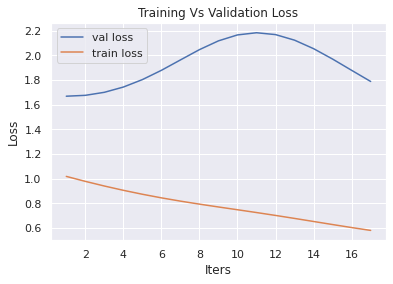

In [12]:
predictions = []

for i,train_batch in enumerate(train_batches):
    
    training_loss = []
    validation_loss = []
    
    print("Training batch " + str(i) + "/" + str(len(train_batches)))
    train_data,train_labels,train_dates = train_batch
    test_data,test_labels,test_dates = test_batches[i]
    val_data,val_labels,val_dates = validation_batches[i]
    print("Train Dates: " + train_dates[0] + " " + train_dates[-1])
    print("Val Dates: " + val_dates[0] + " " + val_dates[-1])
    print("Test Dates: " + test_dates[0] + " " + test_dates[-1])


    train_data = np.reshape(train_data, (train_data.shape[0],train_data.shape[1]*train_data.shape[2]))
    test_data = np.reshape(test_data, (test_data.shape[0],test_data.shape[1]*test_data.shape[2]))
    val_data = np.reshape(val_data, (val_data.shape[0],val_data.shape[1]*val_data.shape[2]))

    clear_output(wait=True)

    
    train_data = torch.from_numpy(train_data).double().to(device)
    train_labels = torch.from_numpy(train_labels).double().to(device)
    test_data = torch.from_numpy(test_data).double().to(device)
    test_labels = torch.from_numpy(test_labels).double().to(device)
    val_data = torch.from_numpy(val_data).double().to(device)
    val_labels = torch.from_numpy(val_labels).double().to(device)


    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(train_data, train_labels, likelihood).to(device)
    
    model.double()
    
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model).to(device)
    
    training_iter = 150
    
    #for early stopping :
    best_cost=1000000 
    stop = False
    last_improvement=0
    require_improvement = 15
    
    best_model = None
    
    epoch = 0

    while epoch < training_iter and stop == False:
        
        # Find optimal model hyperparameters
        model.train()
        likelihood.train()
        
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_data)
        # Calc loss and backprop gradients
        loss = -mll(output, train_labels)
        loss.backward()
        
        '''print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))'''
        optimizer.step()
        training_loss.append(loss.item())

        
        # Get into evaluation (predictive posterior) mode
        model.eval()
        likelihood.eval()
        
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            ## Calculate the validation loss
            val_loss = -mll(model(val_data), val_labels)
            validation_loss.append(val_loss.item())
            
        ## Early Stopping Here
        #early stopping based on the validation set/ max_steps_without_decrease of the loss value : require_improvement
        avg_cost = val_loss.item()
        if avg_cost < best_cost:
            best_cost = avg_cost
            last_improvement = 0
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, 'GPModel.pt')
        else:
            last_improvement +=1
            
        if last_improvement > require_improvement:
            print("No improvement found during the last iterations, stopping optimization at epoch: " + str(epoch))
            # Break out from the loop.
            stop = True
            
        epoch += 1
      
    model = ExactGPModel(train_data, train_labels, likelihood).double().to(device)
    model.load_state_dict(torch.load('GPModel.pt'))
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_data))
        predictions.append(observed_pred)
        
    index = [i+1 for i in range(len(validation_loss))]
    plt.plot(index, validation_loss ,label = "val loss")
    plt.plot(index, training_loss, label = "train loss")
    plt.xlabel('Iters')
    plt.ylabel('Loss')
    plt.title('Training Vs Validation Loss')
    plt.legend()
    plt.show()

    
    
    #time.sleep(3)

In [13]:
### get the predictions
mean_preds = []
variance_preds = []
lower = []
upper = []
test_dates = []

mde_list = []
rmse_list = []

for i,pred in enumerate(predictions):
    
        _,labels,d = test_batches[i]
        test_dates.append(d)
        mean_preds.append(pred.mean.cpu().detach().numpy())
        variance_preds.append(pred.variance.cpu().detach().numpy())
        
        mde_list.append(utils.mean_directional_accuracy(labels,pred.mean.cpu().detach().numpy()))
        rmse_list.append(utils.rmse(pred.mean.cpu().detach().numpy(), labels))
        
        l, u = pred.confidence_region()
        lower.append(l.cpu().detach().numpy())
        upper.append(u.cpu().detach().numpy())
        
mean_preds = np.array(mean_preds).flatten()
lower = np.array(lower).flatten()
upper = np.array(upper).flatten()
variance_preds = np.array(variance_preds).flatten()

In [14]:
flat_dates = [item for sublist in test_dates for item in sublist]

In [15]:
index = [i+1 for i in range(mean_preds.shape[0])]
val_split_num = [i+1 for i in range(len(mde_list))]

In [16]:
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in flat_dates]

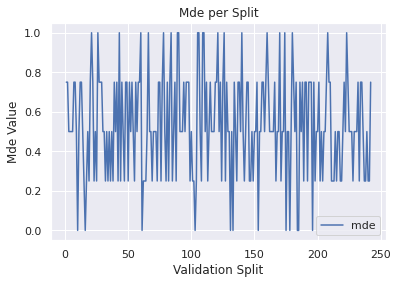

In [17]:
plt.plot(val_split_num, mde_list ,label = "mde")
plt.xlabel('Validation Split')
plt.ylabel('Mde Value')
plt.title('Mde per Split')
plt.legend()
plt.show()

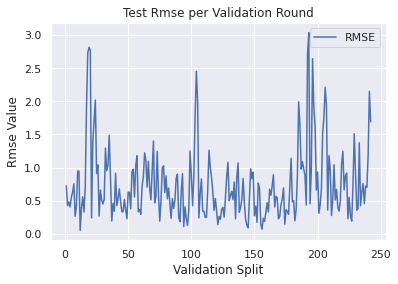

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(val_split_num, rmse_list ,label = "RMSE")
plt.xlabel('Validation Split')
plt.ylabel('Rmse Value')
plt.title('Test Rmse per Validation Round')
plt.legend()
plt.show()
plt.savefig('drive/MyDrive/Visualisations/RMSE_per_Split_' + str(KERNEL) + '_window_' + str(WINDOW) + '.png')

In [19]:
test_labels = []
for i,test_batch in enumerate(test_batches):
    _,l,_ = test_batch
    test_labels.append(l)
test_labels = np.array(test_labels).flatten()

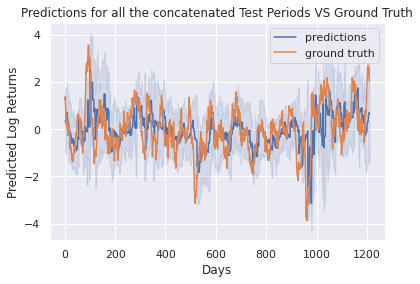

<Figure size 432x288 with 0 Axes>

In [20]:
fig, ax = plt.subplots()
ax.plot(index,mean_preds,label = 'predictions')
plt.plot(index, test_labels, label = "ground truth")
ax.fill_between(index, lower, upper, color='b', alpha=.15)
plt.xlabel('Days')
plt.ylabel('Predicted Log Returns')
plt.title('Predictions for all the concatenated Test Periods VS Ground Truth')
plt.legend()
plt.show()
plt.savefig('drive/MyDrive/Visualisations/PredictionsVsGroundTruth_' + str(KERNEL) + '_window_' + str(WINDOW) + '.png')

In [21]:
print("Mean Directional Accuracy: " + str(utils.mean_directional_accuracy(test_labels,mean_preds)))
print("Root Mean Squared Error : " + str(utils.rmse(mean_preds, test_labels)))

Mean Directional Accuracy: 0.5376344086021505
Root Mean Squared Error : 0.9270904207956203


In [22]:
lower,upper  = utils.calculate_conf_interval(mean_preds,variance_preds)

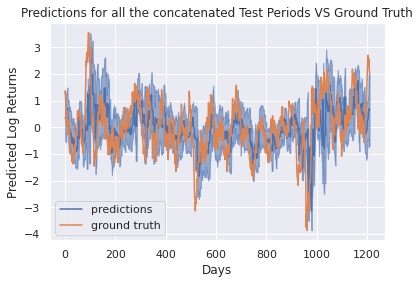

<Figure size 432x288 with 0 Axes>

In [23]:
fig, ax = plt.subplots()
ax.plot(index,mean_preds,label = 'predictions')
plt.plot(index, test_labels, label = "ground truth")
ax.fill_between(index, lower, upper, color='b', alpha=.55)
plt.xlabel('Days')
plt.ylabel('Predicted Log Returns')
plt.title('Predictions for all the concatenated Test Periods VS Ground Truth')
plt.legend()
plt.show()
plt.savefig('drive/MyDrive/Visualisations/PredictionsVsGroundTruth_' + str(KERNEL) + '_window_' + str(WINDOW) + '.png')

No handles with labels found to put in legend.


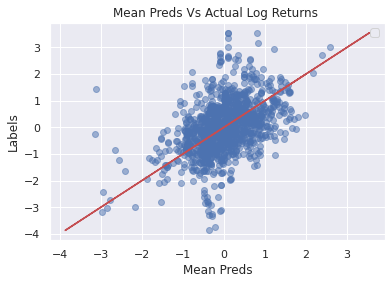

In [24]:
fig, ax = plt.subplots()
plt.scatter(mean_preds, test_labels,alpha=0.5)
plt.plot(test_labels, test_labels, c = 'r')
plt.xlabel('Mean Preds')
plt.ylabel('Labels')
plt.title('Mean Preds Vs Actual Log Returns ')
plt.legend()
plt.show()

In [25]:
inside_m, inside_b, outside_m, outside_b = utils.bound_analysis_plot(mean_preds,test_labels,upper,lower)

792
418
Inside outside Percentage: 65.45454545454545-34.54545454545455


No handles with labels found to put in legend.


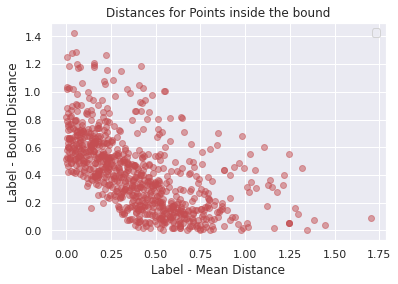

In [26]:
fig, ax = plt.subplots()
plt.scatter(inside_m, inside_b,alpha=0.5, c = 'r')
plt.xlabel('Label - Mean Distance')
plt.ylabel('Label - Bound Distance')
plt.title('Distances for Points inside the bound')
plt.legend()
plt.show()

No handles with labels found to put in legend.


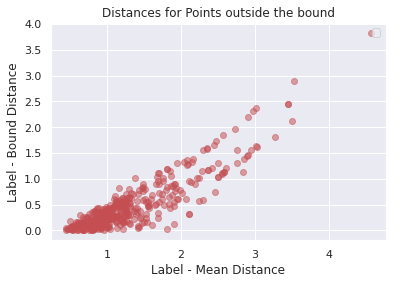

In [27]:
fig, ax = plt.subplots()
plt.scatter(outside_m, outside_b,alpha=0.5, c = 'r')
plt.xlabel('Label - Mean Distance')
plt.ylabel('Label - Bound Distance')
plt.title('Distances for Points outside the bound')
plt.legend()
plt.show()